In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score
import pickle
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

- This notebook was used to train the MLP models based on the hyperparameters found in the gridsearches.

# Importing Data:

In [2]:
X_train = pd.read_csv('Data/X_train_mlp.csv')
X_val = pd.read_csv('Data/X_val_mlp.csv')
X_test = pd.read_csv('Data/X_test.csv')
y_train = pd.read_csv('Data/y_train_mlp.csv', header = None)
y_val = pd.read_csv('Data/y_val_mlp.csv', header = None)
y_test = pd.read_csv('Data/y_test.csv', header = None)

In [3]:
print("X_train Length: {:,}".format(len(X_train)))
print("X_val Length:   {:,}".format(len(X_val)))
print("X_test Length:  {:,}".format(len(X_test)))
print("~~~~~~~~~~~~~~~~~~~~~~~~")
print("y_train Length: {:,}".format(len(y_train)))
print("y_val Length:   {:,}".format(len(y_val)))
print("y_test Length:  {:,}".format(len(y_test)))

X_train Length: 371,847
X_val Length:   92,962
X_test Length:  116,203
~~~~~~~~~~~~~~~~~~~~~~~~
y_train Length: 371,847
y_val Length:   92,962
y_test Length:  116,203


## Applying normalisation:
- We are normalizing the data between 0 and 1.
- This step is performed after separation into train/val/test sets as the data is normalized respective to itself.
- The scaler is fit on the training set and then applied to the val/test sets to avoid data leakage. 

In [4]:
# Definining Scaler:
scaler = MinMaxScaler()

# Fitting scaler on X_train:
X_train = scaler.fit_transform(X_train)

# Applying to validation and test set:
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Applying Sampling Techniques:

In [58]:
def get_count(array, cov_type, percent):
        # Count the number of a specific cover type in the current split array to define sampling bounds:
        count = round(array.tolist().count(cov_type)*percent)
        return count

In [59]:
resample = TomekLinks(sampling_strategy=[1,2])
X_train_samp, y_train_samp = resample.fit_resample(X_train, y_train)

In [60]:
print("X_train Length:   {:,}".format(len(X_train)))
print("y_train Length:  {:,}".format(len(y_train)))
print("~~~~~~~~~~~~~~~~~~~~~~~~")
print("X_train_samp Length:   {:,}".format(len(X_train_samp)))
print("y_train_samp Length:  {:,}".format(len(y_train_samp)))

X_train Length:   371,847
y_train Length:  371,847
~~~~~~~~~~~~~~~~~~~~~~~~
X_train_samp Length:   364,245
y_train_samp Length:  364,245


In [61]:
# Converting y_train into an array to apply sampling:
y_train_samp = np.array(y_train_samp[0])

In [62]:
under_strategy = {1:get_count(y_train_samp, 1, 0.85),
                  2:get_count(y_train_samp, 2, 0.85) }
undersample = RandomUnderSampler(sampling_strategy = under_strategy)

In [63]:
X_train_samp, y_train_samp = undersample.fit_resample(X_train_samp, y_train_samp)

In [64]:
print("X_train_samp Length:   {:,}".format(len(X_train_samp)))
print("y_train_samp Length:  {:,}".format(len(y_train_samp)))

X_train_samp Length:   317,852
y_train_samp Length:  317,852


In [65]:
oversample = SMOTE()

In [66]:
X_train_samp, y_train_samp = oversample.fit_resample(X_train_samp, y_train_samp)

In [14]:
print("X_train_samp Length:   {:,}".format(len(X_train_samp)))
print("y_train_samp Length:  {:,}".format(len(y_train_samp)))

X_train_samp Length:   1,054,893
y_train_samp Length:  1,054,893


In [67]:
unique, counts = np.unique(y_train_samp, return_counts=True)

print(np.asarray((unique, counts)).T)

[[     1 150699]
 [     2 150699]
 [     3 150699]
 [     4 150699]
 [     5 150699]
 [     6 150699]
 [     7 150699]]


## Converting datasets to tensors for input into Pytorch:

In [6]:
# Converting train/test sets to tensors, as the target (y datasets) is categorical it stays in int (or long) format
# Features (X datasets) are converted to float inputs as this is what Pytorch expects:

X_train_tensor = torch.from_numpy(X_train_samp).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float()

# Deduct 1 from the target values (which are 1-7) to account for zero-based indexing:
y_train_tensor = torch.from_numpy(y_train_samp).long() - 1
y_val_tensor = torch.from_numpy(y_val.values).long() - 1
y_test_tensor = torch.from_numpy(y_test.values).long() - 1

# Creating dataloader datasets:
- Pytorch dataloader allows iteration over a dataset via sampling in batches.

In [7]:
# Creating a dataset class based on torch.utils.data.Dataset that can be loaded using train_loader
# source: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class CreatePytorchDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    
    # Altering __len__ and __getitem__ methods from Dataset, so len returns size of dataset and get item 
    # allows dataset indexing by converting any tensor to a list
    
    def __len__(self):
        return len(self.X_data)
    
    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

In [8]:
# Applying the class function above to create datasets to load into Pytorch dataloader:

train_dataset = CreatePytorchDataset(X_train_tensor, y_train_tensor)
val_dataset = CreatePytorchDataset(X_val_tensor, y_val_tensor)
test_dataset = CreatePytorchDataset(X_test_tensor, y_test_tensor)

In [9]:
# Using Pytorch DataLoader to load datasets in batches:
train_loader = DataLoader(train_dataset, 
                         batch_size=512,     # Samples to load per batch
                         shuffle = True     # Whether to shuffle the data at every epoch
                        )

val_loader = DataLoader(val_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True)

# Defining the Multi-Layer Perceptron:

In [13]:
# Creating a class function for the MLP:

class MLP(nn.Module):
    
    def __init__(self, n_features, n_classes, n_neurons, activ, drop):
        super(MLP, self).__init__()
        
        # Define the layers: 
        # Defining the linear tranformations:
        self.fc1 = nn.Linear(n_features, n_neurons)
        self.fc2 = nn.Linear(n_neurons, int(n_neurons/2))
        self.fc3 = nn.Linear(int(n_neurons/2), int(n_neurons/4))
        
        # Output layer
        self.output = nn.Linear(int(n_neurons/4), n_classes)
       
        # Batch normalisation layers 
        # (https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html?highlight=batchnorm#torch.nn.BatchNorm1d)
        self.batchnorm1 = nn.BatchNorm1d(n_neurons)
        self.batchnorm2 = nn.BatchNorm1d(int(n_neurons/2))
        self.batchnorm3 = nn.BatchNorm1d(int(n_neurons/4))
    
        # Defining dropout rate:
        self.dropout = nn.Dropout(drop) 
        
        # Defining hidden layer activation function
        self.activ = activ
        
        
    # Define forward function
    def forward(self, x):
        hidden = self.fc1(x)
        hidden = self.batchnorm1(hidden)
        hidden = self.activ(hidden)
        
        hidden = self.fc2(hidden)
        hidden = self.batchnorm2(hidden)
        hidden = self.activ(hidden)  
        hidden = self.dropout(hidden)
        
        hidden = self.fc3(hidden)
        hidden = self.batchnorm3(hidden)
        hidden = self.activ(hidden)
        hidden = self.dropout(hidden)
        
        output = self.output(hidden)
        
        return output
    

# Defining Model, Criterion and Optimizer:

In [73]:
# FEATURES TO ALTER:
learning_rate = 0.1
n_epochs = 100

## Model:

In [74]:
mlp_model = MLP(n_features=54, n_classes=7, n_neurons=512, activ = nn.LeakyReLU(), drop = 0.1)

## Criterion:

In [10]:
# Choosing Cross Entropy Loss which combines logsoftmax and NLLLoss for use in multi-class classification:
# Source: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

## Optimizer:

In [76]:
optimizer = torch.optim.SGD(mlp_model.parameters(), lr = learning_rate, momentum = 0)

In [77]:
print(mlp_model)

MLP(
  (fc1): Linear(in_features=54, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=7, bias=True)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (activ): LeakyReLU(negative_slope=0.01)
)


# Training the Model:

In [11]:
# Defining a function to calculate accuracy of predictions intra-batch:

def calc_acc(y_pred, y_test):
    # Applies a softmax followed by a log to the y_pred tensor:
    y_pred_torch = torch.log_softmax(y_pred, dim = 1)
    
    # Returns the predicted values for each batch datapoint
    _, y_pred_values = torch.max(y_pred_torch, dim = 1)    
    
    # Calculates correct predictions by comparing to actual values
    correct_pred = (y_pred_values == y_test).float()
    accuracy = correct_pred.sum() / len(correct_pred)
    
    accuracy = accuracy * 100
    
    return accuracy

In [79]:
start = time.time()

# To track lowest validation loss through epochs, set initially to infinity:
min_val_loss = np.Inf

# Lists to hold accuracies and losses through epochs:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(1, n_epochs+1):
    
    # Setting initial losses/accuracy to zero, to be updated within batch loops
    train_loss_epoch = 0
    train_acc_epoch = 0
    val_loss_epoch = 0
    val_acc_epoch = 0
    
    # TRAINING #
    mlp_model.train()
    
    for data, target in train_loader:
        # Set gradients of model parameters to zero:
        optimizer.zero_grad()
        
        # Making predictions based on the training data batch
        y_pred_batch = mlp_model(data)
        
        # Cross-Entropy Loss:
        train_batch_loss = criterion(y_pred_batch, target.flatten())
        
        # Classifications correct within batch, to use to calculate overall accuracy:
        train_batch_acc = calc_acc(y_pred_batch, target.flatten())
        
        # Calculate the sum of gradients using backward:
        train_batch_loss.backward()
        
        # Update parameters by performing a single optimization:
        optimizer.step()
        
        # Update the running loss/accuracy totals:
        train_loss_epoch += train_batch_loss.item()
        train_acc_epoch += train_batch_acc.item()
      
    # Disabling gradient calculation to speed up process, as backward will not be called during validation:
    with torch.no_grad():
        # VALIDATION #
        mlp_model.eval()

        for data, target in val_loader:
            # Use the model to predict target in val set batch:
            y_pred_val_batch =  mlp_model(data)

            # Calculate loss and accuracy on val set:
            val_batch_loss = criterion(y_pred_val_batch, target.flatten())
            val_batch_acc = calc_acc(y_pred_val_batch, target.flatten())

            # Update the running loss/accuracy totals:
            val_loss_epoch += train_batch_loss.item()
            val_acc_epoch += train_batch_acc.item()

    # PRINTING STATISTICS #

    # Calculate metrics across epoch:
    avg_train_loss = train_loss_epoch/ len(train_loader)
    avg_train_acc = train_acc_epoch/ len(train_loader)

    avg_val_loss = val_loss_epoch/ len(val_loader)
    avg_val_acc = val_acc_epoch/ len(val_loader)

    # Display:
    print('Epoch {}: | Train Loss: {:.3f} | Train Acc: {:.3f} | Val Loss: {:.3f}| Val Acc:{:.3f}'.format(
            epoch, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc))

    # Appending lists outside epoch loop to store results:
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

    # SAVING BEST MODEL #
    if avg_val_loss <= min_val_loss:
        # Save model with lowest validation set loss to that point:
        torch.save(mlp_model.state_dict(), 'Models/opt_model.pt')
        # Alter min loss to current avg_val_loss:
        min_val_loss = avg_val_loss

    # EARLY STOPPING CRITERIA #
    # If validation loss has increased for 5 consequetive epochs, end loop:
    # Only run if > 10 epochs gone
    if epoch > 10Now:
        # Checks if the last 5 val_losses are all larger than the preceeding one:
        if ((val_loss_list[-1]>val_loss_list[-2]) and (val_loss_list[-2]>val_loss_list[-3]) and 
            (val_loss_list[-3]>val_loss_list[-4]) and (val_loss_list[-4]>val_loss_list[-5]) and 
            (val_loss_list[-5]>val_loss_list[-6])):
            break 
            
            
print(time.time() - start)

Epoch 1: | Train Loss: 0.452 | Train Acc: 81.685 | Val Loss: 0.331| Val Acc:87.861
Epoch 2: | Train Loss: 0.300 | Train Acc: 88.214 | Val Loss: 0.277| Val Acc:89.017
Epoch 3: | Train Loss: 0.253 | Train Acc: 90.157 | Val Loss: 0.152| Val Acc:94.220
Epoch 4: | Train Loss: 0.225 | Train Acc: 91.278 | Val Loss: 0.208| Val Acc:93.064
Epoch 5: | Train Loss: 0.207 | Train Acc: 92.033 | Val Loss: 0.218| Val Acc:93.642
Epoch 6: | Train Loss: 0.192 | Train Acc: 92.647 | Val Loss: 0.275| Val Acc:88.439
Epoch 7: | Train Loss: 0.180 | Train Acc: 93.073 | Val Loss: 0.185| Val Acc:91.329
Epoch 8: | Train Loss: 0.171 | Train Acc: 93.446 | Val Loss: 0.136| Val Acc:94.220
Epoch 9: | Train Loss: 0.163 | Train Acc: 93.780 | Val Loss: 0.237| Val Acc:91.908
Epoch 10: | Train Loss: 0.156 | Train Acc: 94.040 | Val Loss: 0.218| Val Acc:92.486
Epoch 11: | Train Loss: 0.151 | Train Acc: 94.245 | Val Loss: 0.156| Val Acc:93.642
Epoch 12: | Train Loss: 0.146 | Train Acc: 94.444 | Val Loss: 0.124| Val Acc:95.376
E

Epoch 99: | Train Loss: 0.065 | Train Acc: 97.584 | Val Loss: 0.077| Val Acc:97.110
Epoch 100: | Train Loss: 0.064 | Train Acc: 97.594 | Val Loss: 0.110| Val Acc:95.376
6744.308698177338


## Saving results to dataframe/csv:

In [80]:
mlp_sampled_epochs_df =  pd.DataFrame(
                    {'Train Loss': train_loss_list,
                     'Train Accuracy': train_acc_list,
                     'Validation Loss': val_loss_list,
                     'Validation Accuracy': val_acc_list
                        })

In [81]:
mlp_sampled_epochs_df.to_csv('Data/mlp_100sampled_epochs_df.csv')

# Evaluating on Test Set:

## Loading best model from training above:


In [82]:
# Used to load the best model found within epochs above:
mlp_model.load_state_dict(torch.load('Models/opt_model.pt'))

<All keys matched successfully>

In [93]:
# Saving Model:
#pickle.dump(mlp_model, open('Models/mlp_sampled_model.sav', 'wb'))

In [14]:
# Used to load the optimal model found and saved:
loaded_model = pickle.load(open('Models/mlp_sampled_model.sav', 'rb'))

## Testing on the Test Set

In [84]:
start = time.time()

# Setting the cumulative loss and accuracy to zero, to be updated within for loop below.
cum_test_loss = 0
cum_test_acc = 0

# Creating lists that will hold all predicted and actual target values tested
all_preds_list = []
all_actual_list = []

    
# TESTING #
loaded_model.eval()

for data, target in test_loader:
    # Predictions on test set batches
    y_pred_batch = loaded_model(data)

    # Cross-Entropy Loss and Accuracy:
    test_batch_loss = criterion(y_pred_batch, target.flatten())
    test_batch_acc = calc_acc(y_pred_batch, target.flatten())

    # Updating cumulative running totals:
    cum_test_loss += test_batch_loss.item()
    cum_test_acc += test_batch_acc.item()

    # Adding predictions/actual target to lists for confusion matrix:
    # Applies a softmax followed by a log to the y_pred tensor:
    y_pred_softmax = torch.log_softmax(y_pred_batch, dim = 1)
    # Returns the predicted values for each batch datapoint (the maximums within each logsoftmax'd tensor)
    _, y_pred_values = torch.max(y_pred_softmax, dim = 1) 

    # Converting predictions and actual target and storing in lists above:
    all_preds_list += (list(y_pred_values.numpy()))
    all_actual_list += (list(target.flatten().numpy()))

# PRINTING STATISTICS #
avg_test_loss = cum_test_loss / len(test_loader)
avg_test_acc = cum_test_acc / len(test_loader)


# Display:
print('Test Loss: {:.3f} | Test Acc: {:.3f}'.format(avg_test_loss, avg_test_acc))
        
print("Time taken (seconds): ", time.time() - start)  

Test Loss: 0.180 | Test Acc: 93.506
Time taken (seconds):  2.176884412765503


## Plotting Confusion Matrices:

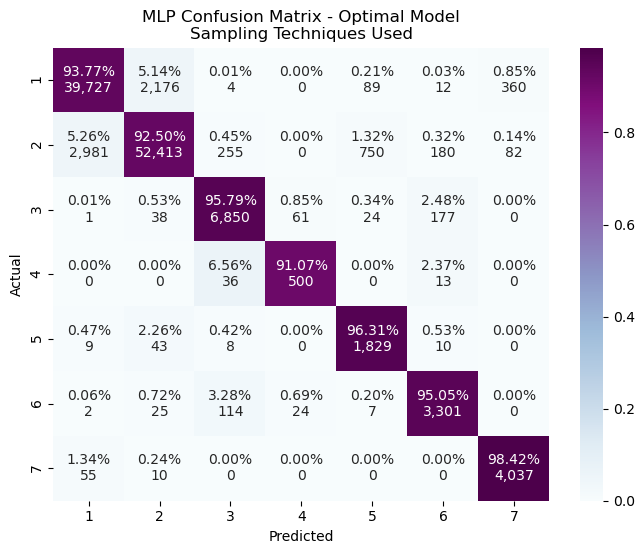

In [92]:
fig = plt.figure(figsize=(8,6), dpi=100)

confusion_matrix1 = pd.crosstab(np.array(all_actual_list)+1, 
                               np.array(all_preds_list)+1,
                               rownames=['Actual'], colnames=['Predicted'])
confusion_matrix2 = pd.crosstab(np.array(all_actual_list)+1, 
                               np.array(all_preds_list)+1,
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')


# Extracting counts and percentages from the matrices above:
counts = ["{0:,}".format(value) for value in
                confusion_matrix1.to_numpy().flatten()]

percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix2.to_numpy().flatten()]

# Combining counts and percentages as one label:
labels = [f"{v1}\n{v2}" for v1, v2 in zip(percentages, counts)]

# Reshaping the labels to fit the array:
labels = np.asarray(labels).reshape(7,7)

#Plotting the heatmap:
sns.heatmap(confusion_matrix2, annot=labels, fmt='', cmap='BuPu')
plt.title("MLP Confusion Matrix - Optimal Model\nSampling Techniques Used")
#plt.savefig('Figures/MLP_Conf_Mat.png', bbox_inches='tight')
plt.show()

In [86]:
print(classification_report(all_actual_list, all_preds_list, labels=[0, 1, 2, 3, 4, 5, 6]))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93     42368
           1       0.96      0.93      0.94     56661
           2       0.94      0.96      0.95      7151
           3       0.85      0.91      0.88       549
           4       0.68      0.96      0.80      1899
           5       0.89      0.95      0.92      3473
           6       0.90      0.98      0.94      4102

    accuracy                           0.94    116203
   macro avg       0.88      0.95      0.91    116203
weighted avg       0.94      0.94      0.94    116203



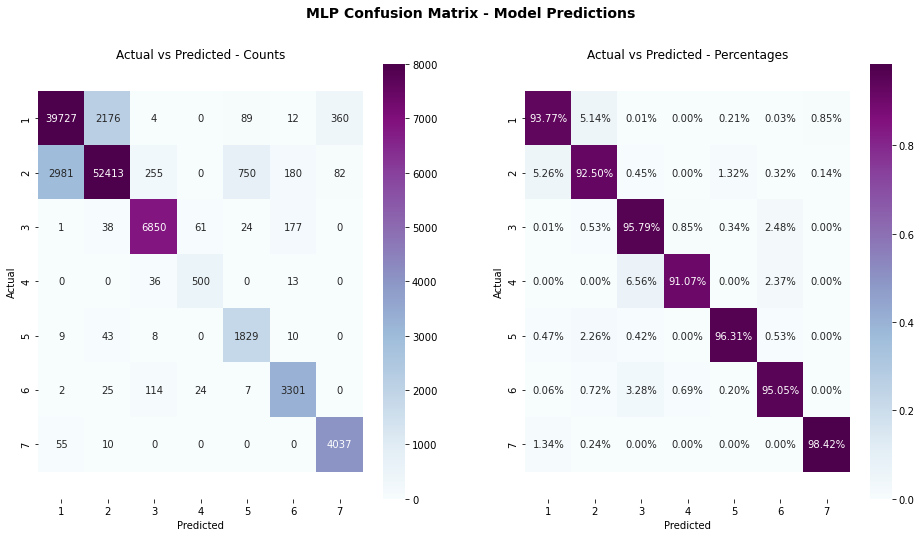

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))

confusion_matrix1 = pd.crosstab(np.array(all_actual_list)+1, 
                               np.array(all_preds_list)+1,
                               rownames=['Actual'], colnames=['Predicted'])
confusion_matrix2 = pd.crosstab(np.array(all_actual_list)+1, 
                               np.array(all_preds_list)+1,
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')


sns.heatmap(confusion_matrix1, annot=True, fmt='g', cmap = 'BuPu', vmax = 8000, ax = ax[0])
sns.heatmap(confusion_matrix2, annot=True, fmt=".2%", cmap = 'BuPu', ax = ax[1])

# Using the below to correct for errors in correlogram, making the squares uneven
bottom, top = ax[0].get_ylim()
ax[0].set_ylim(bottom + 0.5, top - 0.5)
bottom, top = ax[1].get_ylim()
ax[1].set_ylim(bottom + 0.5, top - 0.5)
ax[0].set_title("Actual vs Predicted - Counts")
ax[1].set_title("Actual vs Predicted - Percentages")

plt.suptitle("MLP Confusion Matrix - Model Predictions\n", fontsize = (14), fontweight = 'bold')
#plt.savefig('Figures/MLP_Conf_Mat.png', bbox_inches='tight')
plt.show()

# Comparison to Model without Sampling Techniques:

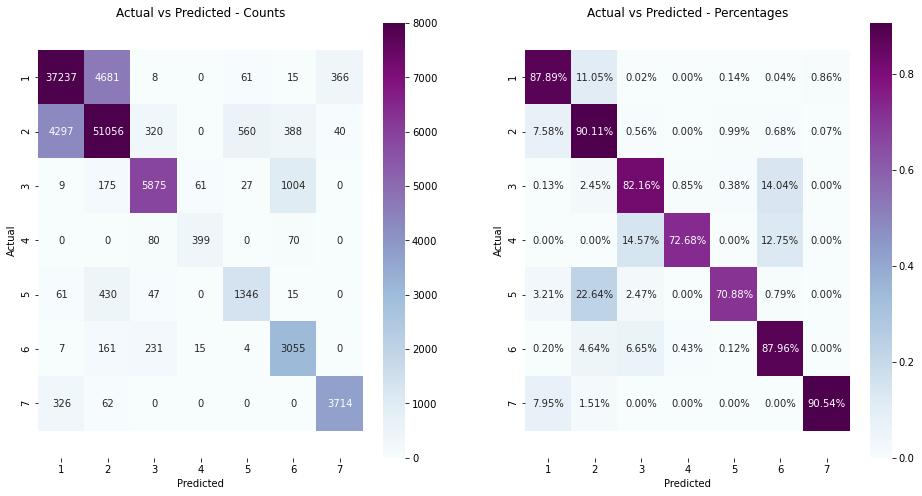

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))

confusion_matrix1 = pd.crosstab(np.array(all_actual_list)+1, 
                               np.array(all_preds_list)+1,
                               rownames=['Actual'], colnames=['Predicted'])
confusion_matrix2 = pd.crosstab(np.array(all_actual_list)+1, 
                               np.array(all_preds_list)+1,
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')


sns.heatmap(confusion_matrix1, annot=True, fmt='g', cmap = 'BuPu', vmax = 8000, ax = ax[0])
sns.heatmap(confusion_matrix2, annot=True, fmt=".2%", cmap = 'BuPu', ax = ax[1])

# Using the below to correct for errors in correlogram, making the squares uneven
bottom, top = ax[0].get_ylim()
ax[0].set_ylim(bottom + 0.5, top - 0.5)
bottom, top = ax[1].get_ylim()
ax[1].set_ylim(bottom + 0.5, top - 0.5)
ax[0].set_title("Actual vs Predicted - Counts")
ax[1].set_title("Actual vs Predicted - Percentages")

#plt.suptitle("Confusion Matrix - Model Predictions\n")
plt.show()

In [46]:
print(classification_report(all_actual_list, all_preds_list, labels=[0, 1, 2, 3, 4, 5, 6]))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     42368
           1       0.90      0.90      0.90     56661
           2       0.90      0.82      0.86      7151
           3       0.84      0.73      0.78       549
           4       0.67      0.71      0.69      1899
           5       0.67      0.88      0.76      3473
           6       0.90      0.91      0.90      4102

    accuracy                           0.88    116203
   macro avg       0.82      0.83      0.83    116203
weighted avg       0.89      0.88      0.88    116203

